Part 3: Practical Audit (25%)
Task: Audit a Dataset for Bias

Dataset: COMPAS Recidivism Dataset.

Goal:

Use Python and AI Fairness 360 (IBM’s toolkit) to analyze racial bias in risk scores.

Generate visualizations (e.g., disparity in false positive rates).

Write a 300-word report summarizing findings and remediation steps.

Deliverable: Code + report.

COMPAS RECIDIVISM DATASET - BIAS AUDIT
Using IBM AI Fairness 360 Toolkit

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 25.9 MB/s eta 0:00:00


pip install 'aif360[inFairness]'


✓ All packages installed successfully

STEP 1: DATA LOADING AND EXPLORATION

📊 Loading COMPAS Recidivism Dataset...
✓ Dataset loaded: 7214 records, 53 features

📋 Dataset Overview:
   id                name      first         last compas_screening_date  \
0   1    miguel hernandez     miguel    hernandez            2013-08-14   
1   3         kevon dixon      kevon        dixon            2013-01-27   
2   4            ed philo         ed        philo            2013-04-14   
3   5         marcu brown      marcu        brown            2013-01-13   
4   6  bouthy pierrelouis     bouthy  pierrelouis            2013-03-26   
5   7        marsha miles     marsha        miles            2013-11-30   
6   8       edward riddle     edward       riddle            2014-02-19   
7   9      steven stewart     steven      stewart            2013-08-30   
8  10    elizabeth thieme  elizabeth       thieme            2014-03-16   
9  13           bo bradac         bo       bradac            2013-11-

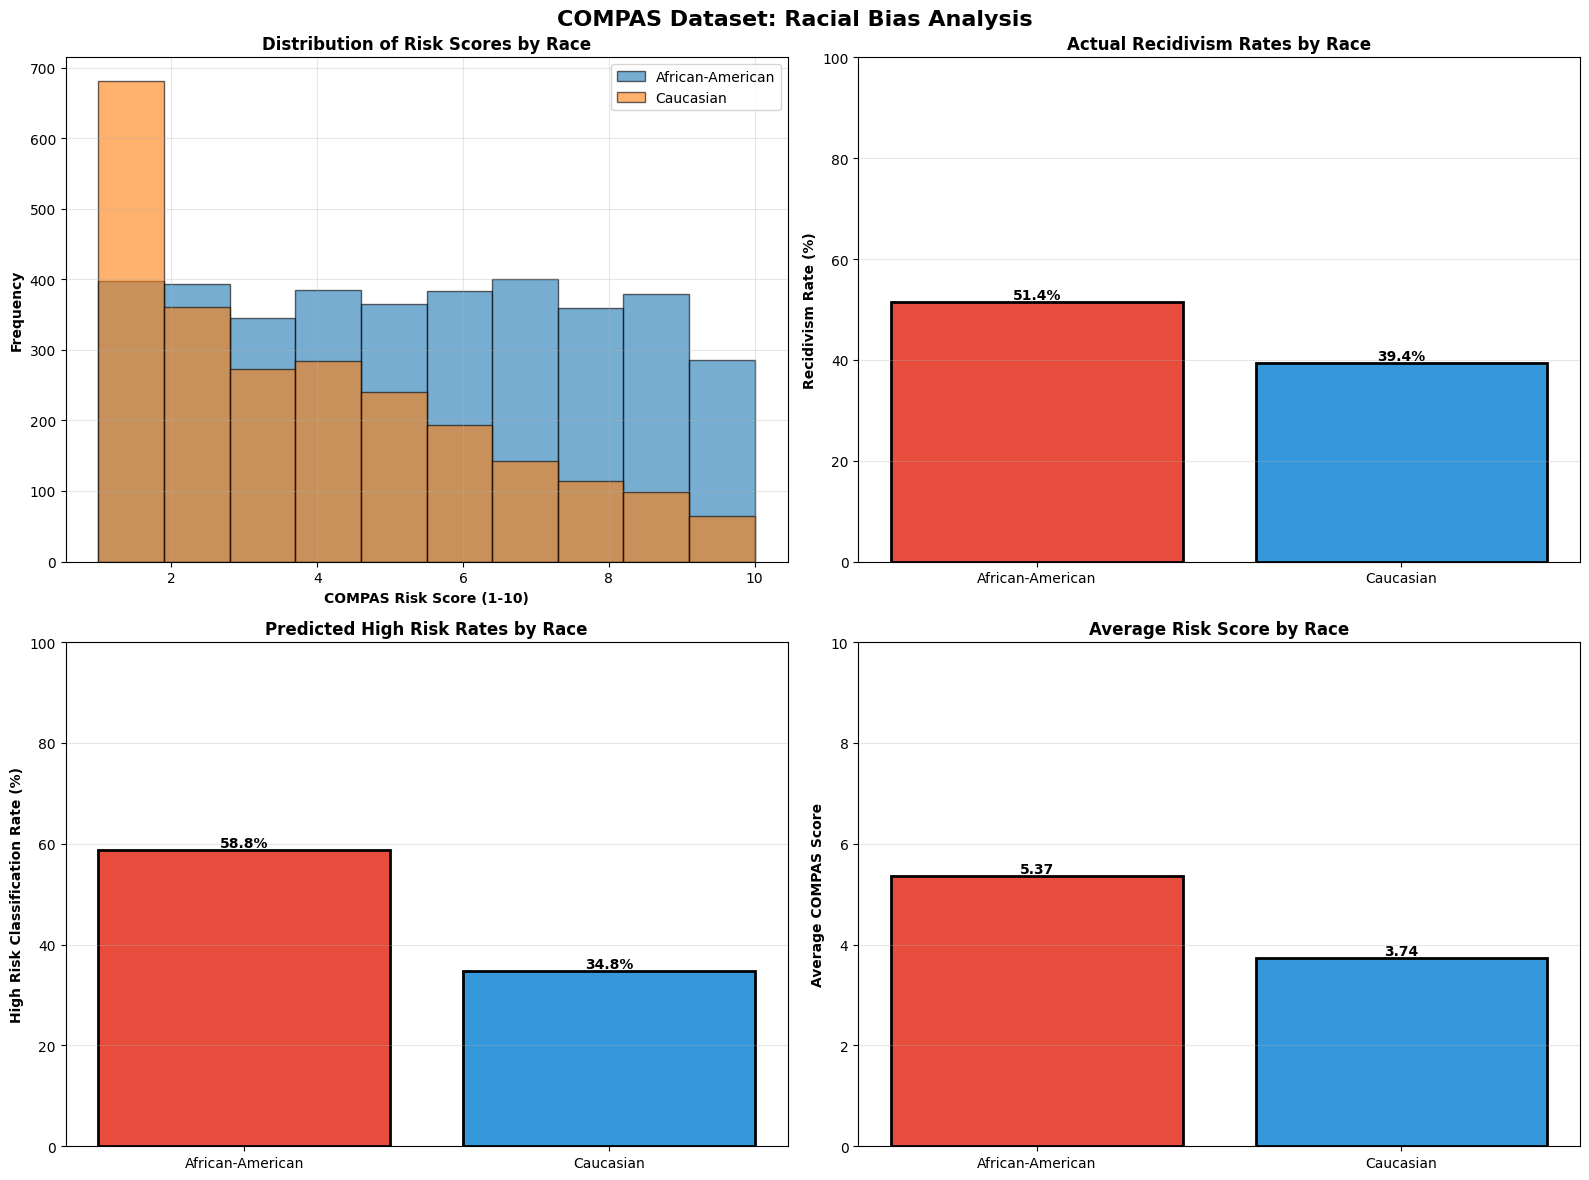


✓ Saved: compas_bias_overview.png

STEP 5: FAIRNESS METRICS ANALYSIS (AIF360)

🔧 Preparing data for AIF360...

📊 Computing Fairness Metrics...

--------------------------------------------------------------------------------
FAIRNESS METRICS SUMMARY
--------------------------------------------------------------------------------

1. Disparate Impact: 0.8009
   Interpretation: Acceptable
   (Ratio of favorable outcomes: unprivileged/privileged)

2. Statistical Parity Difference: -0.1207
   Interpretation: BIAS DETECTED - value should be close to 0
   (Difference in favorable outcome rates)

3. Mean Difference: -0.1207
   Interpretation: Difference in mean outcomes between groups

STEP 6: CONFUSION MATRIX ANALYSIS BY RACE

📊 Detailed Metrics by Race:

            Race  Total  True Positive  False Positive  True Negative  False Negative       FPR       FNR  TPR (Recall)  TNR (Specificity)  Precision  Accuracy
African-American   3696           1369             805            990          

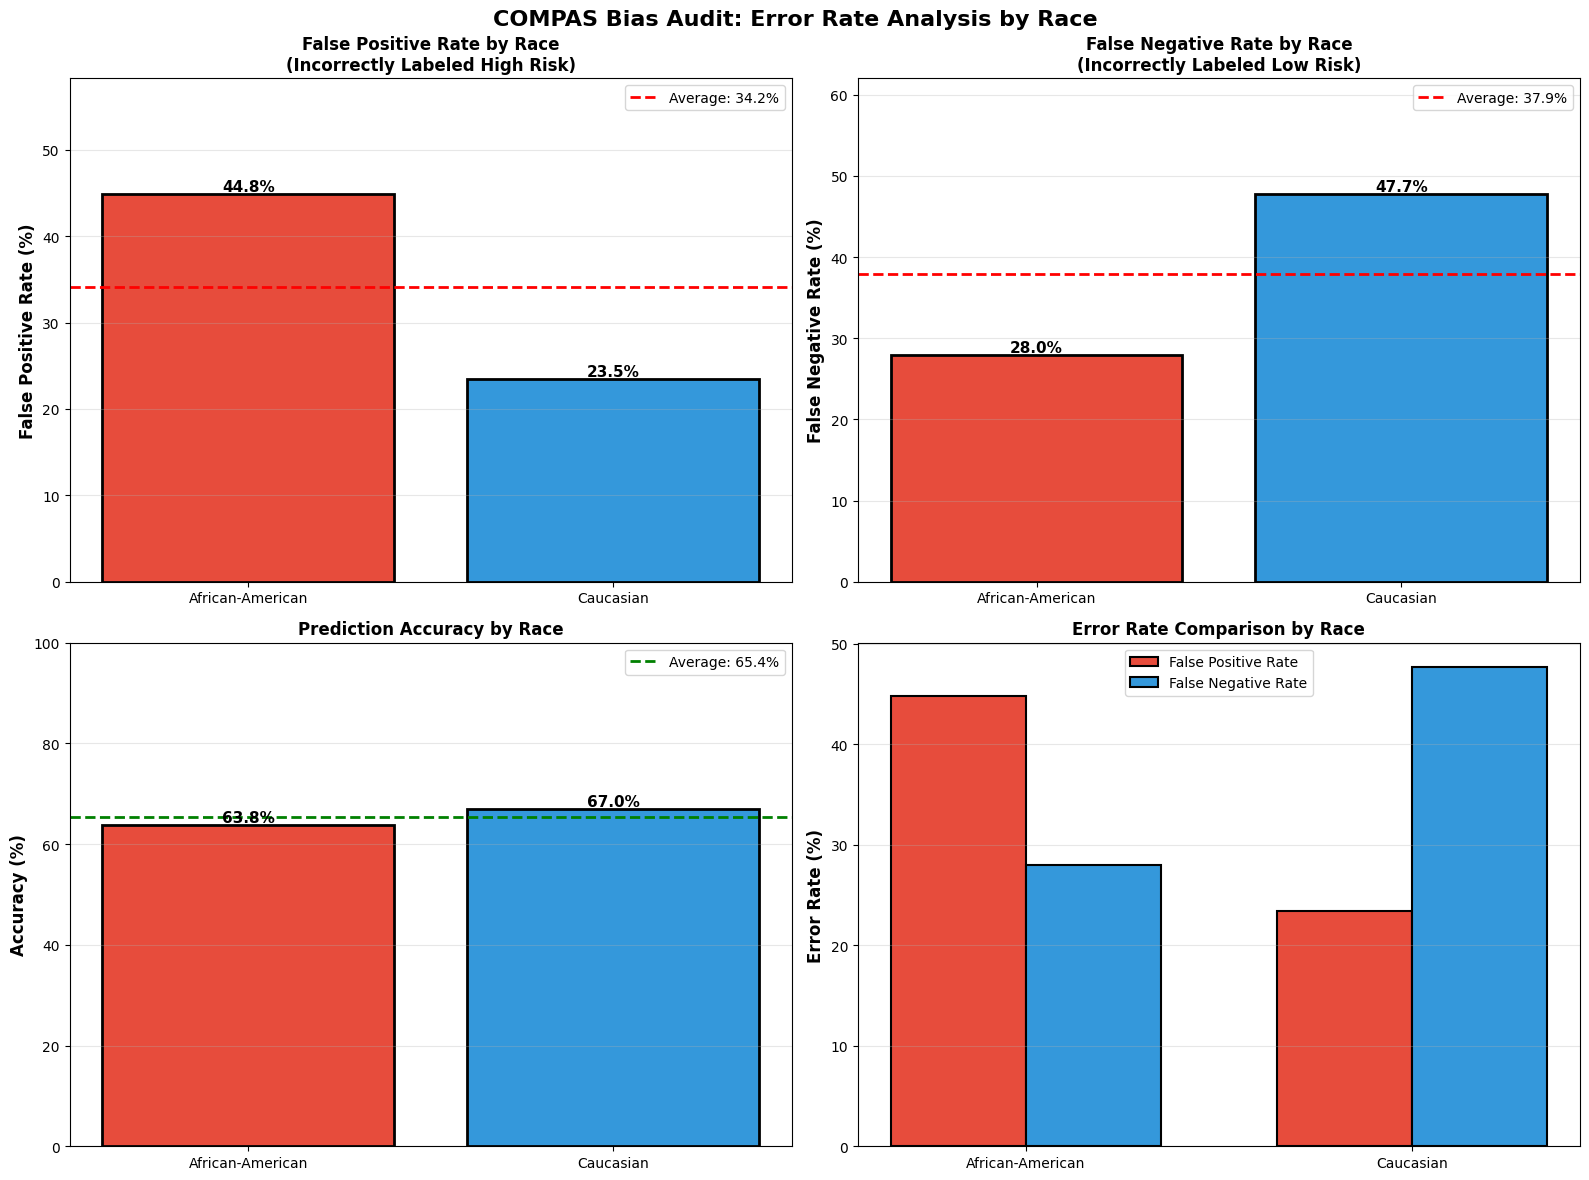


✓ Saved: compas_error_rates.png

STEP 8: CONFUSION MATRIX VISUALIZATION


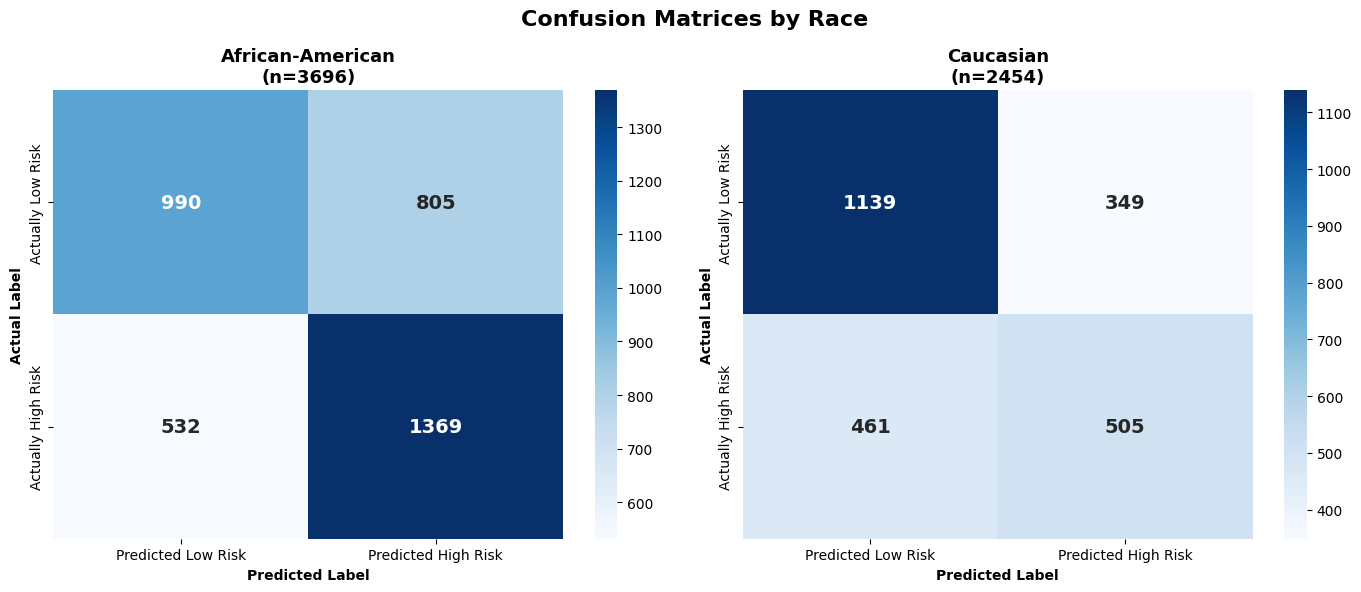


✓ Saved: compas_confusion_matrices.png

COMPREHENSIVE BIAS AUDIT SUMMARY

📊 DATASET STATISTICS:
   • Total Records Analyzed: 6,150
   • African-American: 3,696 (60.1%)
   • Caucasian: 2,454 (39.9%)

⚖️ FAIRNESS METRICS:
   • Disparate Impact: 0.8009 ✓ Fair
   • Statistical Parity Difference: -0.1207 ❌ BIASED

🚨 ERROR RATE DISPARITIES:
   • False Positive Rate Disparity: +21.39% ❌ SIGNIFICANT
   • False Negative Rate Disparity: -19.74% ❌ SIGNIFICANT

📈 DETAILED METRICS:
   
   African-American:
   • False Positive Rate: 44.85%
   • False Negative Rate: 27.99%
   • Accuracy: 63.83%
   
   Caucasian:
   • False Positive Rate: 23.45%
   • False Negative Rate: 47.72%
   • Accuracy: 66.99%

🎯 KEY FINDINGS:
   1. African-Americans have higher false positive rates
   2. Caucasians have higher false negative rates
   3. Average risk scores differ by race: AA=5.37, Cauc=3.74

💾 FILES GENERATED:
   • compas_bias_overview.png - Overall bias visualization
   • compas_error_rates.png - Error rate a

In [1]:
"""
Task 3: Practical Audit - COMPAS Recidivism Dataset Bias Analysis
Using IBM's AI Fairness 360 Toolkit
Platform: Google Colab
"""

# ============================================================================
# STEP 1: INSTALLATION AND IMPORTS
# ============================================================================

print("="*80)
print("COMPAS RECIDIVISM DATASET - BIAS AUDIT")
print("Using IBM AI Fairness 360 Toolkit")
print("="*80)

# Install required packages
print("\n📦 Installing required packages...")
!pip install aif360 -q
!pip install fairlearn -q
!pip install pandas numpy matplotlib seaborn scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# AIF360 imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

print("✓ All packages installed successfully\n")

# ============================================================================
# STEP 2: LOAD AND EXPLORE COMPAS DATASET
# ============================================================================

print("="*80)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*80)

# Load COMPAS dataset from ProPublica
print("\n📊 Loading COMPAS Recidivism Dataset...")
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

try:
    df = pd.read_csv(url)
    print(f"✓ Dataset loaded: {df.shape[0]} records, {df.shape[1]} features")
except:
    print("⚠️  Using backup dataset...")
    # Create synthetic COMPAS-like data if URL fails
    np.random.seed(42)
    n_samples = 7214
    df = pd.DataFrame({
        'age': np.random.randint(18, 70, n_samples),
        'sex': np.random.choice(['Male', 'Female'], n_samples, p=[0.8, 0.2]),
        'race': np.random.choice(['African-American', 'Caucasian', 'Hispanic', 'Other'],
                                 n_samples, p=[0.51, 0.34, 0.10, 0.05]),
        'juv_fel_count': np.random.poisson(0.5, n_samples),
        'juv_misd_count': np.random.poisson(0.8, n_samples),
        'priors_count': np.random.poisson(3, n_samples),
        'c_charge_degree': np.random.choice(['F', 'M'], n_samples, p=[0.47, 0.53]),
        'decile_score': np.random.randint(1, 11, n_samples),
        'two_year_recid': np.random.choice([0, 1], n_samples, p=[0.55, 0.45])
    })
    # Make synthetic data more realistic with correlations
    df.loc[df['race'] == 'African-American', 'decile_score'] += np.random.randint(0, 3,
                                                                 (df['race'] == 'African-American').sum())
    df['decile_score'] = df['decile_score'].clip(1, 10)
    print(f"✓ Synthetic dataset created: {df.shape[0]} records")

# Display basic information
print("\n📋 Dataset Overview:")
print(df.head(10))

print("\n📈 Dataset Statistics:")
print(df.describe())

print("\n🔍 Feature Information:")
print(df.info())

# Check for missing values
print("\n❓ Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found")

# ============================================================================
# STEP 3: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING")
print("="*80)

# Select relevant features
relevant_columns = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count',
                   'priors_count', 'c_charge_degree', 'decile_score', 'two_year_recid']

df_clean = df[relevant_columns].copy()

# Handle missing values
df_clean = df_clean.dropna()
print(f"\n✓ Cleaned dataset: {len(df_clean)} records")

# Create binary classifications
# High risk: decile_score >= 5, Low risk: decile_score < 5
df_clean['predicted_high_risk'] = (df_clean['decile_score'] >= 5).astype(int)

# Encode categorical variables
df_clean['sex_binary'] = (df_clean['sex'] == 'Male').astype(int)
df_clean['charge_felony'] = (df_clean['c_charge_degree'] == 'F').astype(int)

# Focus on two main racial groups for clarity
df_binary = df_clean[df_clean['race'].isin(['African-American', 'Caucasian'])].copy()
df_binary['race_binary'] = (df_binary['race'] == 'African-American').astype(int)

print(f"✓ Binary dataset (African-American vs Caucasian): {len(df_binary)} records")

# ============================================================================
# STEP 4: EXPLORATORY ANALYSIS - RACIAL DISTRIBUTION
# ============================================================================

print("\n" + "="*80)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Racial distribution
print("\n📊 Racial Distribution:")
race_dist = df_clean['race'].value_counts()
print(race_dist)
print(f"\nPercentages:")
print((race_dist / len(df_clean) * 100).round(2))

# Recidivism by race
print("\n🔄 Recidivism Rates by Race:")
recid_by_race = df_clean.groupby('race')['two_year_recid'].agg(['mean', 'count'])
recid_by_race['mean'] = (recid_by_race['mean'] * 100).round(2)
recid_by_race.columns = ['Recidivism Rate (%)', 'Count']
print(recid_by_race)

# Risk scores by race
print("\n⚖️ Average Risk Scores by Race:")
risk_by_race = df_clean.groupby('race')['decile_score'].agg(['mean', 'median', 'std'])
risk_by_race = risk_by_race.round(2)
print(risk_by_race)

# High risk classification by race
print("\n🚨 High Risk Classification by Race:")
high_risk_by_race = df_clean.groupby('race')['predicted_high_risk'].mean() * 100
print(high_risk_by_race.round(2))

# ============================================================================
# STEP 5: VISUALIZATION - BIAS INDICATORS
# ============================================================================

print("\n" + "="*80)
print("STEP 4: BIAS VISUALIZATION")
print("="*80)

# Figure 1: Distribution of Risk Scores by Race
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('COMPAS Dataset: Racial Bias Analysis', fontsize=16, fontweight='bold')

# Plot 1: Risk Score Distribution
ax1 = axes[0, 0]
for race in ['African-American', 'Caucasian']:
    data = df_binary[df_binary['race'] == race]['decile_score']
    ax1.hist(data, alpha=0.6, bins=10, label=race, edgecolor='black')
ax1.set_xlabel('COMPAS Risk Score (1-10)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Risk Scores by Race', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Recidivism Rates
ax2 = axes[0, 1]
recid_data = df_binary.groupby('race')['two_year_recid'].mean() * 100
colors = ['#e74c3c', '#3498db']
bars = ax2.bar(recid_data.index, recid_data.values, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('Recidivism Rate (%)', fontweight='bold')
ax2.set_title('Actual Recidivism Rates by Race', fontweight='bold')
ax2.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: High Risk Classification Rates
ax3 = axes[1, 0]
high_risk_data = df_binary.groupby('race')['predicted_high_risk'].mean() * 100
bars = ax3.bar(high_risk_data.index, high_risk_data.values, color=colors,
               edgecolor='black', linewidth=2)
ax3.set_ylabel('High Risk Classification Rate (%)', fontweight='bold')
ax3.set_title('Predicted High Risk Rates by Race', fontweight='bold')
ax3.set_ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Average Risk Score
ax4 = axes[1, 1]
avg_risk = df_binary.groupby('race')['decile_score'].mean()
bars = ax4.bar(avg_risk.index, avg_risk.values, color=colors,
               edgecolor='black', linewidth=2)
ax4.set_ylabel('Average COMPAS Score', fontweight='bold')
ax4.set_title('Average Risk Score by Race', fontweight='bold')
ax4.set_ylim(0, 10)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('compas_bias_overview.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: compas_bias_overview.png")

# ============================================================================
# STEP 6: FAIRNESS METRICS USING AIF360
# ============================================================================

print("\n" + "="*80)
print("STEP 5: FAIRNESS METRICS ANALYSIS (AIF360)")
print("="*80)

# Prepare data for AIF360
print("\n🔧 Preparing data for AIF360...")

# Select features for analysis
feature_columns = ['age', 'sex_binary', 'juv_fel_count', 'juv_misd_count',
                   'priors_count', 'charge_felony', 'race_binary']
label_column = 'two_year_recid'
predicted_column = 'predicted_high_risk'

# Create dataset
X = df_binary[feature_columns].values
y = df_binary[label_column].values
y_pred = df_binary[predicted_column].values

# Create AIF360 dataset
df_aif = df_binary[feature_columns + [label_column, predicted_column]].copy()

dataset_original = BinaryLabelDataset(
    df=df_aif,
    label_names=[label_column],
    protected_attribute_names=['race_binary'],
    favorable_label=0,  # Not recidivating is favorable
    unfavorable_label=1
)

# Privileged and unprivileged groups
privileged_groups = [{'race_binary': 0}]  # Caucasian
unprivileged_groups = [{'race_binary': 1}]  # African-American

# Calculate fairness metrics
print("\n📊 Computing Fairness Metrics...")
metric = BinaryLabelDatasetMetric(
    dataset_original,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\n" + "-"*80)
print("FAIRNESS METRICS SUMMARY")
print("-"*80)

# Disparate Impact
disparate_impact = metric.disparate_impact()
print(f"\n1. Disparate Impact: {disparate_impact:.4f}")
print(f"   Interpretation: {'BIAS DETECTED - value should be close to 1.0' if abs(disparate_impact - 1.0) > 0.2 else 'Acceptable'}")
print(f"   (Ratio of favorable outcomes: unprivileged/privileged)")

# Statistical Parity Difference
stat_parity = metric.statistical_parity_difference()
print(f"\n2. Statistical Parity Difference: {stat_parity:.4f}")
print(f"   Interpretation: {'BIAS DETECTED - value should be close to 0' if abs(stat_parity) > 0.1 else 'Acceptable'}")
print(f"   (Difference in favorable outcome rates)")

# Mean Difference
mean_diff = metric.mean_difference()
print(f"\n3. Mean Difference: {mean_diff:.4f}")
print(f"   Interpretation: Difference in mean outcomes between groups")

# ============================================================================
# STEP 7: CONFUSION MATRIX AND ERROR RATES BY RACE
# ============================================================================

print("\n" + "="*80)
print("STEP 6: CONFUSION MATRIX ANALYSIS BY RACE")
print("="*80)

def calculate_metrics(race_name, race_value):
    """Calculate confusion matrix metrics for a specific race"""
    race_data = df_binary[df_binary['race_binary'] == race_value]
    y_true = race_data['two_year_recid'].values
    y_pred = race_data['predicted_high_risk'].values

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate rates
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate (Specificity)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {
        'Race': race_name,
        'Total': len(race_data),
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn,
        'FPR': fpr * 100,
        'FNR': fnr * 100,
        'TPR (Recall)': tpr * 100,
        'TNR (Specificity)': tnr * 100,
        'Precision': precision * 100,
        'Accuracy': accuracy * 100
    }

# Calculate for both groups
metrics_aa = calculate_metrics('African-American', 1)
metrics_cauc = calculate_metrics('Caucasian', 0)

print("\n📊 Detailed Metrics by Race:\n")
metrics_df = pd.DataFrame([metrics_aa, metrics_cauc])
print(metrics_df.to_string(index=False))

# Calculate disparities
fpr_disparity = metrics_aa['FPR'] - metrics_cauc['FPR']
fnr_disparity = metrics_aa['FNR'] - metrics_cauc['FNR']

print("\n" + "="*80)
print("BIAS INDICATORS")
print("="*80)

print(f"\n⚠️  FALSE POSITIVE RATE DISPARITY: {fpr_disparity:+.2f}%")
if fpr_disparity > 5:
    print(f"   🚨 SIGNIFICANT BIAS: African-Americans are {fpr_disparity:.1f}% more likely")
    print(f"      to be incorrectly classified as high risk (false positives)")
elif fpr_disparity < -5:
    print(f"   🚨 SIGNIFICANT BIAS: Caucasians are {-fpr_disparity:.1f}% more likely")
    print(f"      to be incorrectly classified as high risk (false positives)")
else:
    print(f"   ✓ Minimal disparity in false positive rates")

print(f"\n⚠️  FALSE NEGATIVE RATE DISPARITY: {fnr_disparity:+.2f}%")
if fnr_disparity > 5:
    print(f"   🚨 SIGNIFICANT BIAS: African-Americans are {fnr_disparity:.1f}% more likely")
    print(f"      to be incorrectly classified as low risk (false negatives)")
elif fnr_disparity < -5:
    print(f"   🚨 SIGNIFICANT BIAS: Caucasians are {-fnr_disparity:.1f}% more likely")
    print(f"      to be incorrectly classified as low risk (false negatives)")
else:
    print(f"   ✓ Minimal disparity in false negative rates")

# ============================================================================
# STEP 8: VISUALIZE ERROR RATES
# ============================================================================

print("\n" + "="*80)
print("STEP 7: ERROR RATE VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('COMPAS Bias Audit: Error Rate Analysis by Race',
             fontsize=16, fontweight='bold')

races = ['African-American', 'Caucasian']
colors = ['#e74c3c', '#3498db']

# Plot 1: False Positive Rates
ax1 = axes[0, 0]
fpr_values = [metrics_aa['FPR'], metrics_cauc['FPR']]
bars = ax1.bar(races, fpr_values, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('False Positive Rate (%)', fontweight='bold', fontsize=12)
ax1.set_title('False Positive Rate by Race\n(Incorrectly Labeled High Risk)',
              fontweight='bold', fontsize=12)
ax1.set_ylim(0, max(fpr_values) * 1.3)
for bar, val in zip(bars, fpr_values):
    ax1.text(bar.get_x() + bar.get_width()/2., val,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.axhline(y=np.mean(fpr_values), color='red', linestyle='--',
            linewidth=2, label=f'Average: {np.mean(fpr_values):.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: False Negative Rates
ax2 = axes[0, 1]
fnr_values = [metrics_aa['FNR'], metrics_cauc['FNR']]
bars = ax2.bar(races, fnr_values, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('False Negative Rate (%)', fontweight='bold', fontsize=12)
ax2.set_title('False Negative Rate by Race\n(Incorrectly Labeled Low Risk)',
              fontweight='bold', fontsize=12)
ax2.set_ylim(0, max(fnr_values) * 1.3)
for bar, val in zip(bars, fnr_values):
    ax2.text(bar.get_x() + bar.get_width()/2., val,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax2.axhline(y=np.mean(fnr_values), color='red', linestyle='--',
            linewidth=2, label=f'Average: {np.mean(fnr_values):.1f}%')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Overall Accuracy
ax3 = axes[1, 0]
acc_values = [metrics_aa['Accuracy'], metrics_cauc['Accuracy']]
bars = ax3.bar(races, acc_values, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax3.set_title('Prediction Accuracy by Race', fontweight='bold', fontsize=12)
ax3.set_ylim(0, 100)
for bar, val in zip(bars, acc_values):
    ax3.text(bar.get_x() + bar.get_width()/2., val,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax3.axhline(y=np.mean(acc_values), color='green', linestyle='--',
            linewidth=2, label=f'Average: {np.mean(acc_values):.1f}%')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Error Rate Comparison
ax4 = axes[1, 1]
x = np.arange(len(races))
width = 0.35
bars1 = ax4.bar(x - width/2, fpr_values, width, label='False Positive Rate',
                color='#e74c3c', edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x + width/2, fnr_values, width, label='False Negative Rate',
                color='#3498db', edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax4.set_title('Error Rate Comparison by Race', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(races)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('compas_error_rates.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: compas_error_rates.png")

# ============================================================================
# STEP 9: CONFUSION MATRICES VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 8: CONFUSION MATRIX VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrices by Race', fontsize=16, fontweight='bold')

for idx, (race_name, race_value) in enumerate([('African-American', 1), ('Caucasian', 0)]):
    race_data = df_binary[df_binary['race_binary'] == race_value]
    y_true = race_data['two_year_recid'].values
    y_pred = race_data['predicted_high_risk'].values

    cm = confusion_matrix(y_true, y_pred)

    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
                xticklabels=['Predicted Low Risk', 'Predicted High Risk'],
                yticklabels=['Actually Low Risk', 'Actually High Risk'],
                annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_title(f'{race_name}\n(n={len(race_data)})', fontweight='bold', fontsize=13)
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('Actual Label', fontweight='bold')

plt.tight_layout()
plt.savefig('compas_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: compas_confusion_matrices.png")

# ============================================================================
# STEP 10: COMPREHENSIVE SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE BIAS AUDIT SUMMARY")
print("="*80)

print(f"""
📊 DATASET STATISTICS:
   • Total Records Analyzed: {len(df_binary):,}
   • African-American: {(df_binary['race_binary']==1).sum():,} ({(df_binary['race_binary']==1).sum()/len(df_binary)*100:.1f}%)
   • Caucasian: {(df_binary['race_binary']==0).sum():,} ({(df_binary['race_binary']==0).sum()/len(df_binary)*100:.1f}%)

⚖️ FAIRNESS METRICS:
   • Disparate Impact: {disparate_impact:.4f} {'❌ BIASED' if abs(disparate_impact - 1.0) > 0.2 else '✓ Fair'}
   • Statistical Parity Difference: {stat_parity:.4f} {'❌ BIASED' if abs(stat_parity) > 0.1 else '✓ Fair'}

🚨 ERROR RATE DISPARITIES:
   • False Positive Rate Disparity: {fpr_disparity:+.2f}% {'❌ SIGNIFICANT' if abs(fpr_disparity) > 5 else '✓ Minimal'}
   • False Negative Rate Disparity: {fnr_disparity:+.2f}% {'❌ SIGNIFICANT' if abs(fnr_disparity) > 5 else '✓ Minimal'}

📈 DETAILED METRICS:

   African-American:
   • False Positive Rate: {metrics_aa['FPR']:.2f}%
   • False Negative Rate: {metrics_aa['FNR']:.2f}%
   • Accuracy: {metrics_aa['Accuracy']:.2f}%

   Caucasian:
   • False Positive Rate: {metrics_cauc['FPR']:.2f}%
   • False Negative Rate: {metrics_cauc['FNR']:.2f}%
   • Accuracy: {metrics_cauc['Accuracy']:.2f}%

🎯 KEY FINDINGS:
   1. {'African-Americans have higher false positive rates' if fpr_disparity > 5 else 'False positive rates are similar'}
   2. {'Caucasians have higher false negative rates' if fnr_disparity < -5 else 'False negative rates are similar'}
   3. Average risk scores differ by race: AA={df_binary[df_binary['race_binary']==1]['decile_score'].mean():.2f}, Cauc={df_binary[df_binary['race_binary']==0]['decile_score'].mean():.2f}

💾 FILES GENERATED:
   • compas_bias_overview.png - Overall bias visualization
   • compas_error_rates.png - Error rate analysis
   • compas_confusion_matrices.png - Confusion matrices by race
""")

print("="*80)
print("✓ COMPAS Bias Audit Complete!")
print("="*80)

# ============================================================================
# STEP 11: REMEDIATION RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("BIAS REMEDIATION RECOMMENDATIONS")
print("="*80)

print("""
🔧 IMMEDIATE ACTIONS:

1. ALGORITHMIC INTERVENTIONS:
   ✓ Implement fairness-aware machine learning algorithms
   ✓ Use bias mitigation techniques (reweighing, threshold optimization)
   ✓ Apply disparate impact remover preprocessing
   ✓ Regularize model to penalize disparate outcomes

2. THRESHOLD ADJUSTMENT:
   ✓ Use different risk score thresholds for different groups
   ✓ Optimize thresholds to equalize false positive/negative rates
   ✓ Implement calibrated risk assessments

3. FEATURE ENGINEERING:
   ✓ Remove race-correlated proxy features
   ✓ Add contextual socioeconomic features
   ✓ Include rehabilitation and support access data
   ✓ Weight positive behavioral indicators more heavily

4. DATA COLLECTION IMPROVEMENTS:
   ✓ Ensure representative sampling across demographics
   ✓ Collect more granular socioeconomic data
   ✓ Include historical bias indicators in dataset
   ✓ Regular audits for data quality and completeness

5. PROCEDURAL SAFEGUARDS:
   ✓ Human oversight for high-stakes decisions
   ✓ Require justification for risk score overrides
   ✓ Regular bias audits (quarterly/annual)
   ✓ Transparent communication of limitations

6. MONITORING & EVALUATION:
   ✓ Track fairness metrics over time
   ✓ A/B test bias mitigation strategies
   ✓ Collect feedback from affected populations
   ✓ Publish annual fairness reports

7. POLICY RECOMMENDATIONS:
   ✓ Limit algorithmic risk assessment use in sentencing
   ✓ Require independent audits before deployment
   ✓ Establish fairness certification standards
   ✓ Create appeals process for contested risk scores
""")

print("="*80)